In [2]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import os

sns.set_style("white")


In [3]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [4]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.experiment_name = experiment_name
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}, lr={}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling":
            label = "{}, {}, {}, {}, {}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k,
                                                   self.pool_size,
                                                   self.lr) 
        elif self.strategy == "baseline":
            label = "{}, {}, {}, bs={}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k, 
                                                   self.lr) 

        if self.trial:
            label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()

In [64]:

def plot(xs_by_config, ys_by_config, xlabel, ylabel, plot_dir, smoothing=0, lw=1, ymin=None):
    xmax = - float("inf")
    ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):

        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]

        #TODO get label here
        label = config.label
        print xlabel, ",", ylabel, len(xs), len(ys)
        if config.top_k == config.pool_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.8)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.8)
        
        if max(xs) > xmax:
            xmax = max(xs)
        if max(ys) > ymax:
            ymax = max(ys)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plt.legend(fontsize=8)
        plt.xlim(0, xmax)
        if ymin is not None:
            plt.ylim(ymin, ymax)
        plot_file = "{}_{}_lr{}.pdf".format(config.experiment_name,
                                            ylabel,
                                            config.lr)
        plt.savefig(os.path.join(plot_dir, plot_file))
        plt.show()
        plt.clf()


In [62]:
def plot_experiments(experiment_names, experiments_dir, plot_dir, lrs=None, nets=None, trials=None, smoothing=0):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store":
                continue
            elif filename == "pickles":
                continue

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue

            train_num_backprops = [l.num_backprop for l in train_lines]
            test_num_backprops = [l.num_backprop for l in test_lines]
            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            ratio_backpropped_ys = [l.num_backprop / float(l.num_backprop + l.num_skip) \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]
            ratio_backpropped_xs = [l.num_backprop \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]


            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Trained", "Ratio Backpropped", plot_dir, smoothing, ymin=0)
    plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Trained", "Training Loss", plot_dir, smoothing, lw=0.6)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Trained", "Test Accuracy", plot_dir, smoothing, lw=0.6, ymin=0)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Trained", "Test Loss", plot_dir, smoothing, lw=0.6)

sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial3_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_0.1_32_0.01_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.01_0.0001_trial1_v2
Num Images Trained , Ratio Backpropped 8400 8400
Num Images Trained , Ratio Backpropped 4215 4215
Num Images Trained , Ratio Backpropped 8168 8168
Num Images Trained , Ratio Backpropped 4120 4120
Num Images Trained , Ratio Backpropped 2141 2141


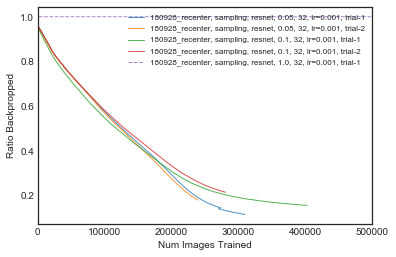

Num Images Trained , Training Loss 509290 509290
Num Images Trained , Training Loss 260142 260142
Num Images Trained , Training Loss 505625 505625
Num Images Trained , Training Loss 256887 256887
Num Images Trained , Training Loss 137094 137094


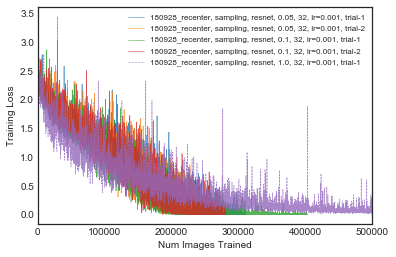

Num Images Trained , Test Accuracy 8401 8401
Num Images Trained , Test Accuracy 4216 4216
Num Images Trained , Test Accuracy 8169 8169
Num Images Trained , Test Accuracy 4121 4121
Num Images Trained , Test Accuracy 2142 2142


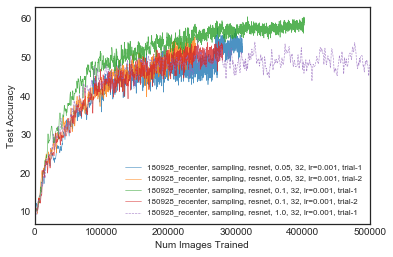

Num Images Trained , Test Loss 8401 8401
Num Images Trained , Test Loss 4216 4216
Num Images Trained , Test Loss 8169 8169
Num Images Trained , Test Loss 4121 4121
Num Images Trained , Test Loss 2142 2142


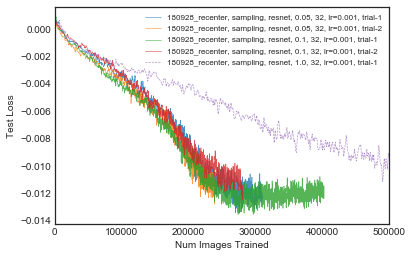

<Figure size 432x288 with 0 Axes>

In [125]:
plot_home_dir = "../plots"

experiment_names = ["180928_recenter"]
experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/181004_attribution/recenter".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
lrs = [0.001]
plot_experiments(experiment_names, experiment_dir, plot_dir, lrs=lrs, trials=[1,2], smoothing=10)

sampling_cifar10_resnet_0.05_32_0.0001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.0001_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.0001_0.0001_trial3_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.0001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.0001_0.0001_trial2_v2
sampling_cifar10_resnet_1_32_0.0001_0.0001_trial3_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
Num Images Trained , Ratio Backpropped 1513 1513
Num Images Trained , Ratio Backpropped 1522 1522
Num Images Trained , Ratio Backpropped 617 617
Num Images Trained , Ratio Backpropped 617 617


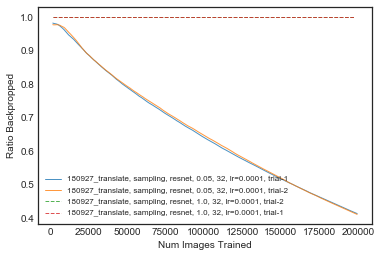

Num Images Trained , Training Loss 96037 96037
Num Images Trained , Training Loss 96572 96572
Num Images Trained , Training Loss 39990 39990
Num Images Trained , Training Loss 39990 39990


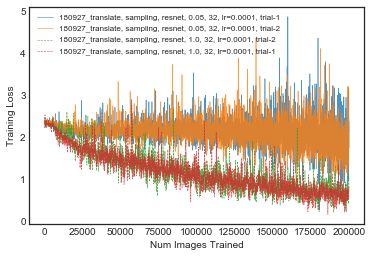

Num Images Trained , Test Accuracy 1514 1514
Num Images Trained , Test Accuracy 1523 1523
Num Images Trained , Test Accuracy 618 618
Num Images Trained , Test Accuracy 618 618


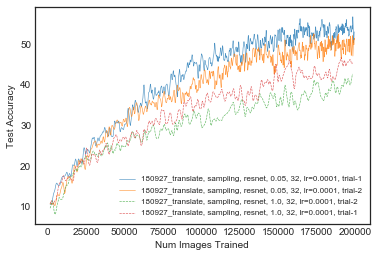

Num Images Trained , Test Loss 1514 1514
Num Images Trained , Test Loss 1523 1523
Num Images Trained , Test Loss 618 618
Num Images Trained , Test Loss 618 618


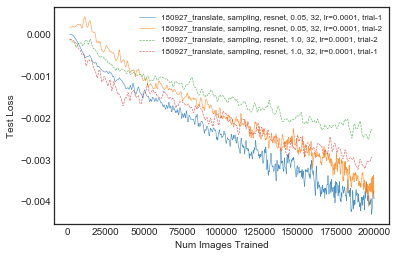

<Figure size 432x288 with 0 Axes>

In [118]:
plot_home_dir = "../plots"

experiment_names = ["180927_translate"]
experiment_dir = "../data/output/cifar10/"
plot_dir =  "{}/180927_translate".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
lrs = [0.0001]
plot_experiments(experiment_names, experiment_dir, plot_dir, lrs=lrs, trials=[1,2], smoothing=10)

sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_32_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial3_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_0.1_32_0.01_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0

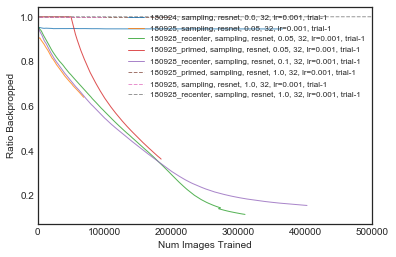

Num Images Trained , Training Loss 35666 35666
Num Images Trained , Training Loss 21722 21722
Num Images Trained , Training Loss 509290 509290
Num Images Trained , Training Loss 100892 100892
Num Images Trained , Training Loss 505625 505625
Num Images Trained , Training Loss 39990 39990
Num Images Trained , Training Loss 20438 20438
Num Images Trained , Training Loss 137094 137094


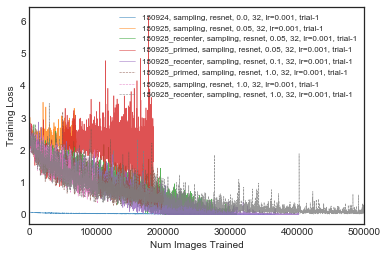

Num Images Trained , Test Accuracy 1272 1272
Num Images Trained , Test Accuracy 334 334
Num Images Trained , Test Accuracy 8401 8401
Num Images Trained , Test Accuracy 1595 1595
Num Images Trained , Test Accuracy 8169 8169
Num Images Trained , Test Accuracy 618 618
Num Images Trained , Test Accuracy 311 311
Num Images Trained , Test Accuracy 2142 2142


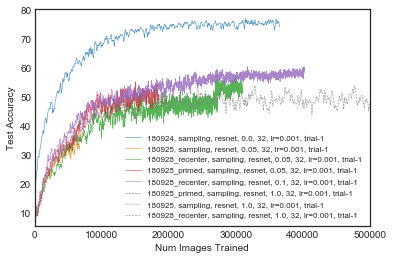

Num Images Trained , Test Loss 1272 1272
Num Images Trained , Test Loss 334 334
Num Images Trained , Test Loss 8401 8401
Num Images Trained , Test Loss 1595 1595
Num Images Trained , Test Loss 8169 8169
Num Images Trained , Test Loss 618 618
Num Images Trained , Test Loss 311 311
Num Images Trained , Test Loss 2142 2142


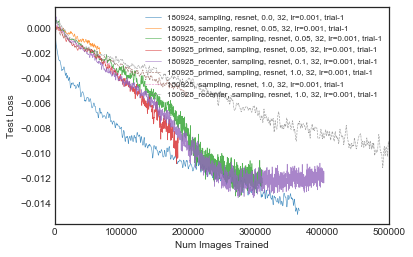

<Figure size 432x288 with 0 Axes>

In [129]:
plot_home_dir = "../plots"

experiment_names = ["181001_baseline", "180924", "180925", "180925_primed", "180928_recenter"] #"180927_translate", 
experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/181004_attribution/all".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
lrs = [0.001]
nets = ["resnet"]
plot_experiments(experiment_names, experiment_dir, plot_dir, lrs=lrs, nets=nets, trials=[1], smoothing=10)

sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial3_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_0.1_32_0.01_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.01_0.0001_trial1_v2
Num Images Trained , Ratio Backpropped 333 333
Num Images Trained , Ratio Backpropped 8400 8400
Num Images Trained , Ratio Backpropped 1594 1594
N

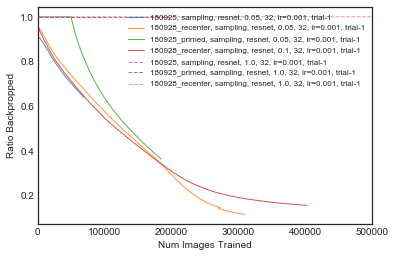

Num Images Trained , Training Loss 21722 21722
Num Images Trained , Training Loss 509290 509290
Num Images Trained , Training Loss 100892 100892
Num Images Trained , Training Loss 505625 505625
Num Images Trained , Training Loss 20438 20438
Num Images Trained , Training Loss 39990 39990
Num Images Trained , Training Loss 137094 137094


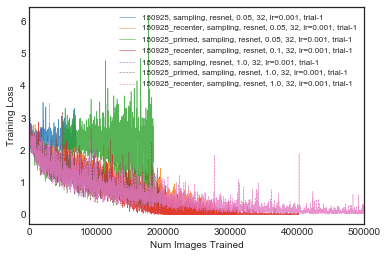

Num Images Trained , Test Accuracy 334 334
Num Images Trained , Test Accuracy 8401 8401
Num Images Trained , Test Accuracy 1595 1595
Num Images Trained , Test Accuracy 8169 8169
Num Images Trained , Test Accuracy 311 311
Num Images Trained , Test Accuracy 618 618
Num Images Trained , Test Accuracy 2142 2142


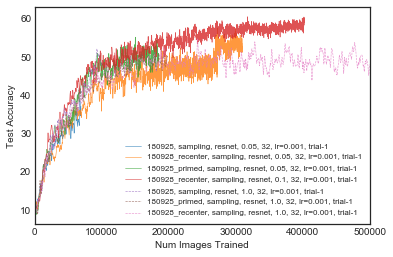

Num Images Trained , Test Loss 334 334
Num Images Trained , Test Loss 8401 8401
Num Images Trained , Test Loss 1595 1595
Num Images Trained , Test Loss 8169 8169
Num Images Trained , Test Loss 311 311
Num Images Trained , Test Loss 618 618
Num Images Trained , Test Loss 2142 2142


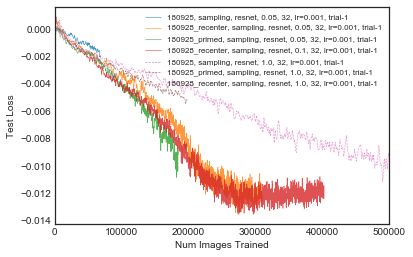

sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial3_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_0.1_32_0.01_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.01_0.0001_trial1_v2
Num Images Trained , Ratio Backpropped 5635 5635
Num Images Trained , Ratio Backpropped 5546 5546
Num Images Trained , Ratio Backpropped 6950 6950

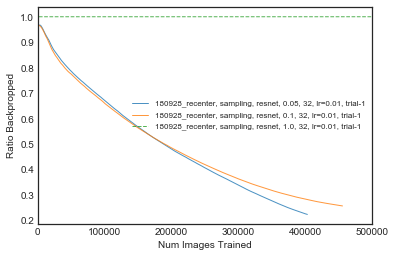

Num Images Trained , Training Loss 351390 351390
Num Images Trained , Training Loss 347746 347746
Num Images Trained , Training Loss 443332 443332


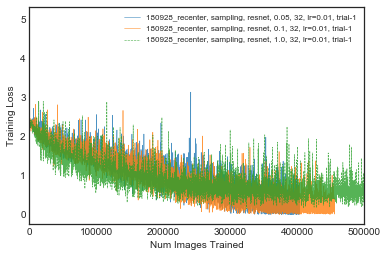

Num Images Trained , Test Accuracy 5636 5636
Num Images Trained , Test Accuracy 5547 5547
Num Images Trained , Test Accuracy 6951 6951


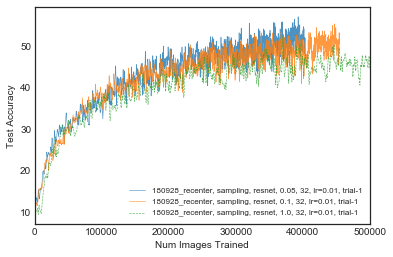

Num Images Trained , Test Loss 5636 5636
Num Images Trained , Test Loss 5547 5547
Num Images Trained , Test Loss 6951 6951


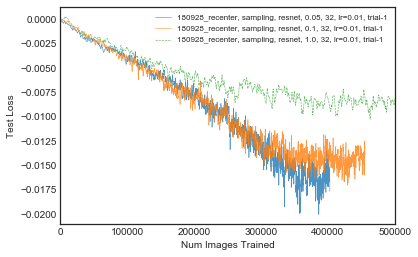

<Figure size 432x288 with 0 Axes>

In [130]:
plot_home_dir = "../plots"

experiment_names = ["180925", "180925_primed", "180928_recenter"] #"180927_translate" DEBUG Add back when ready 
experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/181004_attribution/no24".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
nets = ["resnet"]
lrs = [0.001]
plot_experiments(experiment_names, experiment_dir, plot_dir, lrs=lrs, nets=nets, trials=[1], smoothing=10)

lrs = [0.01]
plot_experiments(experiment_names, experiment_dir, plot_dir, lrs=lrs, nets=nets, trials=[1], smoothing=10)

sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial2_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial2_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial2_v2
topk_cifar10_mobilenet_32_32_0.001_0.0001_trial1_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial1_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial2_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial2_v2


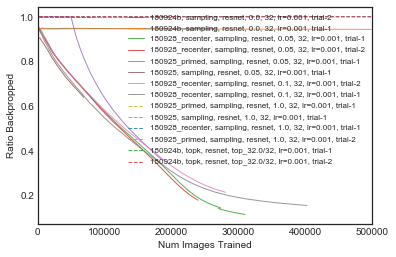

Num Images Trained , Training Loss 26106 26106
Num Images Trained , Training Loss 48578 48578
Num Images Trained , Training Loss 509290 509290
Num Images Trained , Training Loss 260142 260142
Num Images Trained , Training Loss 100892 100892
Num Images Trained , Training Loss 21722 21722
Num Images Trained , Training Loss 256887 256887
Num Images Trained , Training Loss 505625 505625
Num Images Trained , Training Loss 39990 39990
Num Images Trained , Training Loss 20438 20438
Num Images Trained , Training Loss 137094 137094
Num Images Trained , Training Loss 39990 39990
Num Images Trained , Training Loss 7330 7330
Num Images Trained , Training Loss 43722 43722


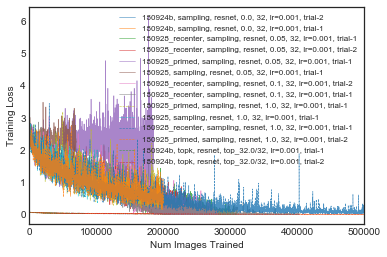

Num Images Trained , Test Accuracy 928 928
Num Images Trained , Test Accuracy 1735 1735
Num Images Trained , Test Accuracy 8401 8401
Num Images Trained , Test Accuracy 4216 4216
Num Images Trained , Test Accuracy 1595 1595
Num Images Trained , Test Accuracy 334 334
Num Images Trained , Test Accuracy 4121 4121
Num Images Trained , Test Accuracy 8169 8169
Num Images Trained , Test Accuracy 618 618
Num Images Trained , Test Accuracy 311 311
Num Images Trained , Test Accuracy 2142 2142
Num Images Trained , Test Accuracy 618 618
Num Images Trained , Test Accuracy 254 254
Num Images Trained , Test Accuracy 1561 1561


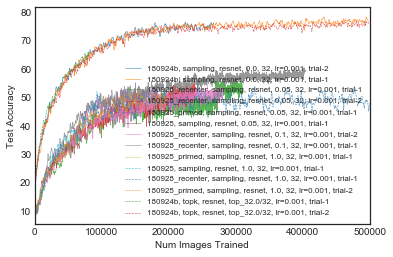

Num Images Trained , Test Loss 928 928
Num Images Trained , Test Loss 1735 1735
Num Images Trained , Test Loss 8401 8401
Num Images Trained , Test Loss 4216 4216
Num Images Trained , Test Loss 1595 1595
Num Images Trained , Test Loss 334 334
Num Images Trained , Test Loss 4121 4121
Num Images Trained , Test Loss 8169 8169
Num Images Trained , Test Loss 618 618
Num Images Trained , Test Loss 311 311
Num Images Trained , Test Loss 2142 2142
Num Images Trained , Test Loss 618 618
Num Images Trained , Test Loss 254 254
Num Images Trained , Test Loss 1561 1561


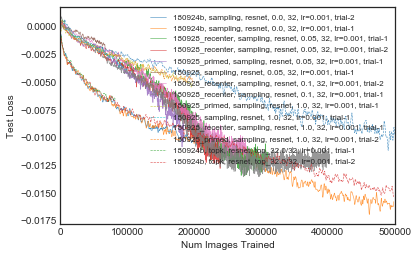

sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial2_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial2_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial2_v2
topk_cifar10_mobilenet_32_32_0.001_0.0001_trial1_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial1_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial2_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial2_v2


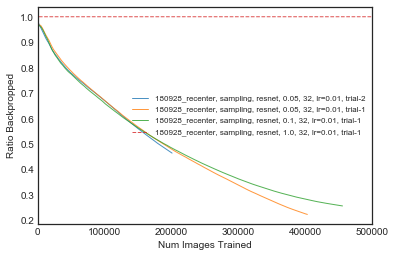

Num Images Trained , Training Loss 85886 85886
Num Images Trained , Training Loss 351390 351390
Num Images Trained , Training Loss 347746 347746
Num Images Trained , Training Loss 443332 443332


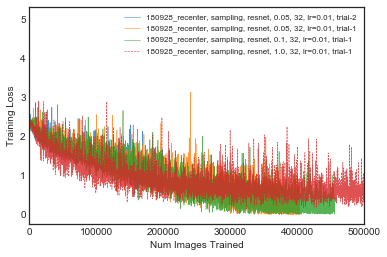

Num Images Trained , Test Accuracy 1352 1352
Num Images Trained , Test Accuracy 5636 5636
Num Images Trained , Test Accuracy 5547 5547
Num Images Trained , Test Accuracy 6951 6951


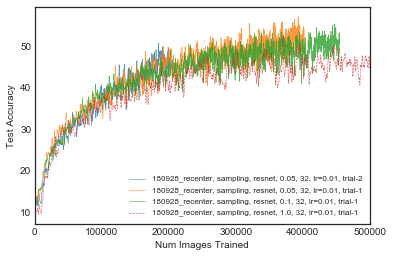

Num Images Trained , Test Loss 1352 1352
Num Images Trained , Test Loss 5636 5636
Num Images Trained , Test Loss 5547 5547
Num Images Trained , Test Loss 6951 6951


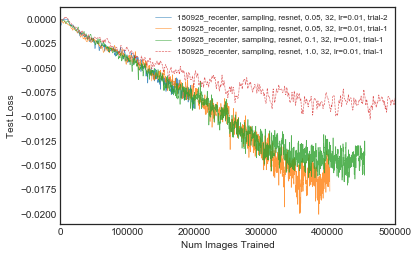

<Figure size 432x288 with 0 Axes>

In [128]:
plot_home_dir = "../plots"

experiment_names = ["180924b", "180925", "180925_primed", "180928_recenter"]  #"180927_translate" DEBUG Add back when ready
experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/181004_attribution/all_with24b".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
nets = ["resnet"]

lrs = [0.001]
plot_experiments(experiment_names, experiment_dir, plot_dir, lrs=lrs, nets = nets, trials=[1,2], smoothing=10)

lrs = [0.01]
plot_experiments(experiment_names, experiment_dir, plot_dir, lrs=lrs, nets = nets, trials=[1,2], smoothing=10)

baseline_cifar10_resnet_64_64_0.1_0.0005_trial1_v2
topk_cifar10_resnet_1_1_0.1_0.0005_trial1_v2
topk_cifar10_resnet_64_64_0.1_0.0005_trial1_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_32_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_1_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.001_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial1_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial2_v2
sampling_cifar10_resnet_0.05_32_0.01_0.0001_trial3_v2
sampling_cifar10_resnet_0.1_32_0.001_0.0001_trial1_v2
sa

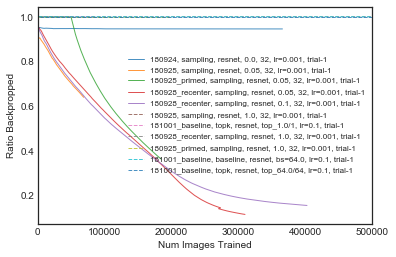

Num Images Trained , Training Loss 35666 35666
Num Images Trained , Training Loss 21722 21722
Num Images Trained , Training Loss 100892 100892
Num Images Trained , Training Loss 509290 509290
Num Images Trained , Training Loss 505625 505625
Num Images Trained , Training Loss 20438 20438
Num Images Trained , Training Loss 16908 16908
Num Images Trained , Training Loss 137094 137094
Num Images Trained , Training Loss 39990 39990
Num Images Trained , Training Loss 11111 11111
Num Images Trained , Training Loss 561606 561606


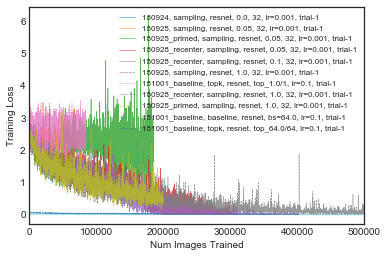

Num Images Trained , Test Accuracy 1272 1272
Num Images Trained , Test Accuracy 334 334
Num Images Trained , Test Accuracy 1595 1595
Num Images Trained , Test Accuracy 8401 8401
Num Images Trained , Test Accuracy 8169 8169
Num Images Trained , Test Accuracy 311 311
Num Images Trained , Test Accuracy 8449 8449
Num Images Trained , Test Accuracy 2142 2142
Num Images Trained , Test Accuracy 618 618
Num Images Trained , Test Accuracy 11111 11111
Num Images Trained , Test Accuracy 4935 4935


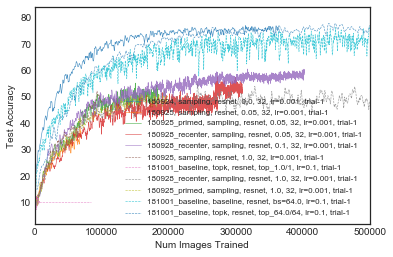

Num Images Trained , Test Loss 1272 1272
Num Images Trained , Test Loss 334 334
Num Images Trained , Test Loss 1595 1595
Num Images Trained , Test Loss 8401 8401
Num Images Trained , Test Loss 8169 8169
Num Images Trained , Test Loss 311 311
Num Images Trained , Test Loss 8449 8449
Num Images Trained , Test Loss 2142 2142
Num Images Trained , Test Loss 618 618
Num Images Trained , Test Loss 11111 11111
Num Images Trained , Test Loss 4935 4935


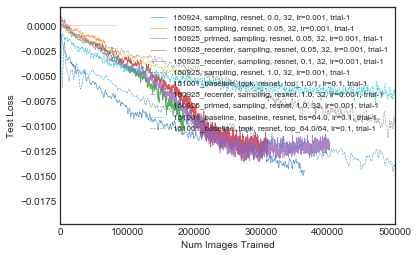

<Figure size 432x288 with 0 Axes>

In [136]:
plot_home_dir = "../plots"

experiment_names = ["181001_baseline", "180924", "180925", "180925_primed", "180928_recenter"] #"180927_translate", 
experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/181004_attribution/all_baseline".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
lrs = [0.001, 0.1]
nets = ["resnet"]
plot_experiments(experiment_names, experiment_dir, plot_dir, lrs=lrs, nets=nets, trials=[1], smoothing=10)

sampling_cifar10_resnet_1_32_0.1_0.0005_trial1_v2
sampling_cifar10_resnet_1_32_0.1_0.0005_trial2_v2
sampling_cifar10_resnet_1_32_0.1_0.0005_trial3_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_32_32_0.001_0.0001_trial1_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial2_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial2_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial2_v2
topk_cifar10_mobilenet_32_32_0.001_0.0001_trial1_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial1_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial2_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0.01_32_0.1_0.0005_trial1_v2
sampling_cifar

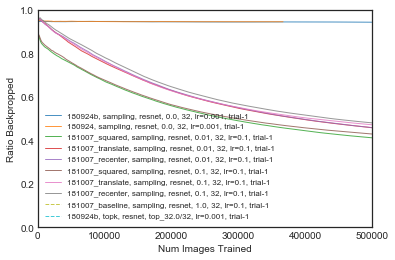

Num Images Trained , Training Loss 48587 48587
Num Images Trained , Training Loss 35675 35675
Num Images Trained , Training Loss 6896 6896
Num Images Trained , Training Loss 6202 6202
Num Images Trained , Training Loss 6193 6193
Num Images Trained , Training Loss 6615 6615
Num Images Trained , Training Loss 6029 6029
Num Images Trained , Training Loss 5912 5912
Num Images Trained , Training Loss 3139 3139
Num Images Trained , Training Loss 7339 7339


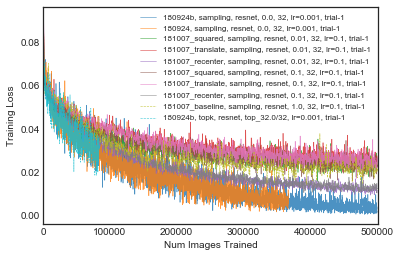

Num Images Trained , Test Accuracy 1744 1744
Num Images Trained , Test Accuracy 1281 1281
Num Images Trained , Test Accuracy 785 785
Num Images Trained , Test Accuracy 706 706
Num Images Trained , Test Accuracy 705 705
Num Images Trained , Test Accuracy 753 753
Num Images Trained , Test Accuracy 686 686
Num Images Trained , Test Accuracy 673 673
Num Images Trained , Test Accuracy 321 321
Num Images Trained , Test Accuracy 263 263


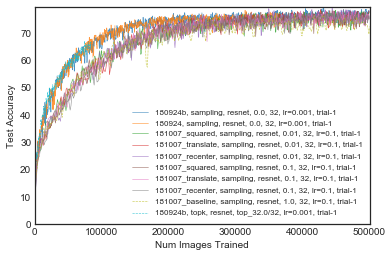

Num Images Trained , Test Loss 1744 1744
Num Images Trained , Test Loss 1281 1281
Num Images Trained , Test Loss 785 785
Num Images Trained , Test Loss 706 706
Num Images Trained , Test Loss 705 705
Num Images Trained , Test Loss 753 753
Num Images Trained , Test Loss 686 686
Num Images Trained , Test Loss 673 673
Num Images Trained , Test Loss 321 321
Num Images Trained , Test Loss 263 263


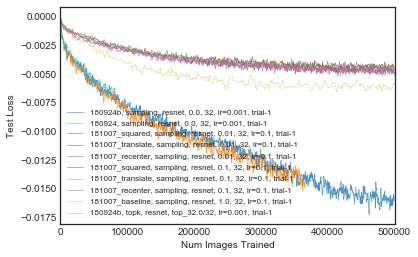

<Figure size 432x288 with 0 Axes>

In [82]:
plot_home_dir = "../plots"

experiment_names = ["181007_baseline", "180924", "180924b", "181007_recenter", "181007_translate", "181007_squared"]
# experiment_names = ["180924", "181007_baseline"]
experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/181007_batching/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_experiments(experiment_names, experiment_dir, plot_dir, nets=["resnet"], lrs=[0.001, 0.01, 0.1], trials=[1], smoothing=1)

